<a href="https://colab.research.google.com/github/mlem283/mmelton3_64061/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup

In [8]:
# Colab/TF/Keras basics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


Load & preprocess IMDB

In [9]:
# Load IMDB dataset (top 10k words)
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=10000)

# One-hot encode reviews into 10,000-dim vectors
def vectorize(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension), dtype="float32")
    for i, seq in enumerate(sequences):
        results[i, seq] = 1.0
    return results

x_train = vectorize(x_train)
x_test  = vectorize(x_test)

# Fixed validation holdout (10k) for fair comparison
x_val = x_train[:10000]
y_val = y_train[:10000]
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

x_train.shape, x_val.shape, x_test.shape


((25000, 10000), (10000, 10000), (25000, 10000))

Model builder

In [10]:
def build_model(hidden_layers=2, units=16, activation="relu", loss="binary_crossentropy"):

    model = keras.Sequential()
    model.add(layers.Input(shape=(10000,)))
    for _ in range(hidden_layers):
        model.add(layers.Dense(units, activation=activation))
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
        loss=loss,
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )
    return model


Train + evaluate

In [11]:
def fit_and_eval(config, epochs=20, batch_size=512):

    model = build_model(**config)
    early = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=2, restore_best_weights=True
    )

    hist = model.fit(
        partial_x_train, partial_y_train,
        validation_data=(x_val, y_val),
        epochs=epochs, batch_size=batch_size, verbose=0,
        callbacks=[early]
    )

    # Pick best epoch by min val_loss
    best_epoch = int(np.argmin(hist.history["val_loss"])) + 1
    best_val_acc = float(hist.history["val_accuracy"][best_epoch - 1])
    best_val_auc = float(hist.history["val_auc"][best_epoch - 1])

    test_loss, test_acc, test_auc = model.evaluate(x_test, y_test, verbose=0)

    return {
        **config,
        "best_epoch": best_epoch,
        "best_val_acc": best_val_acc,
        "best_val_auc": best_val_auc,
        "test_acc": float(test_acc),
        "test_auc": float(test_auc),
    }


Experiment Grid

In [12]:
# Layers: 1, 2, 3
# Units: 16, 32, 64, 128
# Loss: binary_crossentropy vs mse
# Activation: relu vs tanh

layers_list = [1, 2, 3]
units_list  = [16, 32, 64, 128]
loss_list   = ["binary_crossentropy", "mse"]
activations = ["relu", "tanh"]

grid = [
    {"hidden_layers": L, "units": U, "activation": A, "loss": loss}
    for L in layers_list
    for U in units_list
    for A in activations
    for loss in loss_list
]

print("Total configs:", len(grid))  # should be 3 x 4 x 2 x 2 = 48


Total configs: 48


Run the experiments

In [13]:
results = [fit_and_eval(cfg) for cfg in grid]
df = pd.DataFrame(results)
df["config"] = df.apply(lambda r: f"{int(r['hidden_layers'])}L-{int(r['units'])}U-{r['activation']}-{r['loss']}", axis=1)

# Sort for easy inspection
df_sorted = df.sort_values(["best_val_acc", "test_acc"], ascending=False).reset_index(drop=True)

# Save results
df_sorted.to_csv("hparam_summary_full.csv", index=False)
display(df_sorted.head(10))
print("Saved: hparam_summary_full.csv")


,hidden_layers,units,activation,loss,best_epoch,best_val_acc,best_val_auc,test_acc,test_auc,config
0,2,32,relu,binary_crossentropy,3,0.8896,0.953736,0.88236,0.949638,2L-32U-relu-binary_crossentropy
1,3,32,relu,binary_crossentropy,3,0.8893,0.953537,0.88460,0.949392,3L-32U-relu-binary_crossentropy
2,2,128,relu,binary_crossentropy,3,0.8892,0.954328,0.88296,0.950607,2L-128U-relu-binary_crossentropy
3,2,128,tanh,binary_crossentropy,2,0.8891,0.955571,0.88516,0.951136,2L-128U-tanh-binary_crossentropy
4,2,64,tanh,binary_crossentropy,2,0.8890,0.954075,0.88116,0.949982,2L-64U-tanh-binary_crossentropy
5,2,16,relu,binary_crossentropy,5,0.8889,0.953792,0.88208,0.949449,2L-16U-relu-binary_crossentropy
6,3,64,relu,binary_crossentropy,3,0.8886,0.953798,0.88216,0.948518,3L-64U-relu-binary_crossentropy
7,3,64,tanh,binary_crossentropy,2,0.8885,0.954041,0.88216,0.949801,3L-64U-tanh-binary_crossentropy
8,1,64,tanh,binary_crossentropy,4,0.8883,0.954836,0.88304,0.950337,1L-64U-tanh-binary_crossentropy
9,2,16,tanh,mse,4,0.8883,0.953676,0.88180,0.949299,2L-16U-tanh-mse


Saved: hparam_summary_full.csv


Plot results

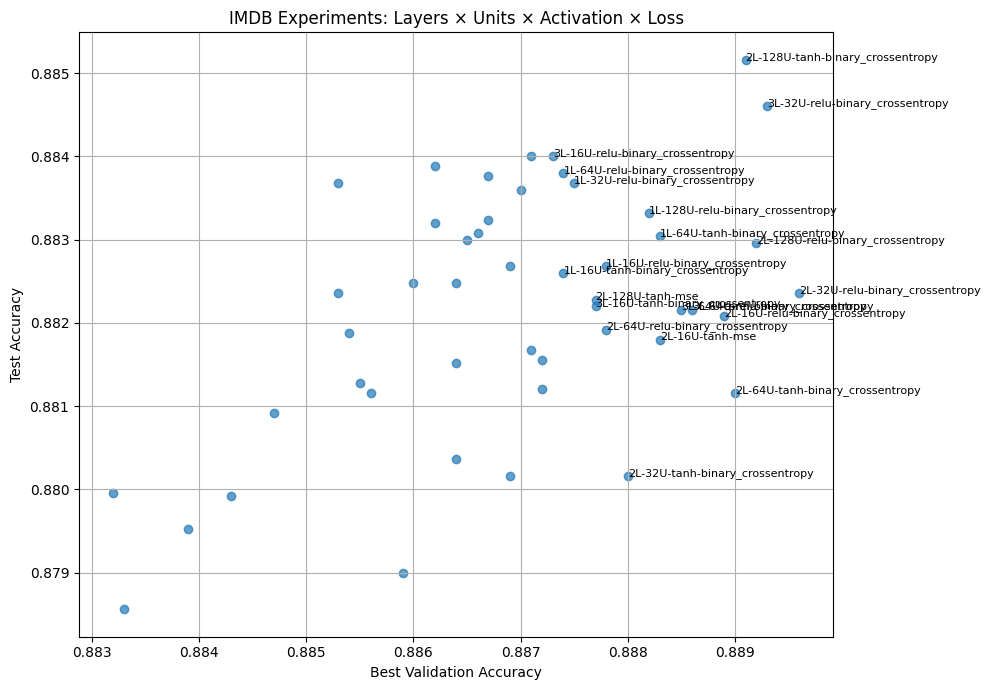

Saved: submission_summary_full.png


In [14]:
plt.figure(figsize=(10, 7))
plt.scatter(df_sorted["best_val_acc"], df_sorted["test_acc"], alpha=0.7)

for _, row in df_sorted.head(20).iterrows():  # annotate top 20
    plt.text(row["best_val_acc"], row["test_acc"], row["config"], fontsize=8)

plt.xlabel("Best Validation Accuracy")
plt.ylabel("Test Accuracy")
plt.title("IMDB Experiments: Layers × Units × Activation × Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig("submission_summary_full.png", dpi=150)
plt.show()

print("Saved: submission_summary_full.png")


When I tested all of the different setups for my neural network, I noticed that the accuracy stayed pretty close no matter what, between about 88% and 89%. Even though the range was small, some patterns stood out. Using binary crossentropy gave me better results than using mean squared error, which makes sense because BCE is designed for yes/no problems like this. I also saw that ReLU worked better than tanh as the activation function, since ReLU helped the model learn more effectively. For the number of layers, two hidden layers gave me the best balance. With only one layer the model was too simple, and with three layers the extra complexity didn’t really help. Finally, when I looked at the number of units in each layer, I found that 32 to 64 units worked the best. Sixteen units were too small, and 128 units sometimes worked but were less reliable. Overall, the best model for me was a simple two-layer network with 32–64 units per layer, ReLU activation, and binary crossentropy loss.